In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from client.image_data_generator import ImageDataGenerator

In [2]:
DATASET_PATH = "./open-images/"
TEST_DATASET_PATH = "./open-images-test/"
MASK_PATH = "./open-images-mask/mask.mat"

EMBEDDING_FEATURE_DIM = 1024

EPOCHS = 10
BATCH_SIZE = 4

In [8]:
train_data = ImageDataGenerator(dataset_path=DATASET_PATH, mask_path=MASK_PATH)
test_data = ImageDataGenerator(dataset_path=TEST_DATASET_PATH, mask_path=MASK_PATH)

In [9]:
train_ds = (
    tf.data.Dataset.from_generator(
        train_data,
        output_types=(tf.float32, tf.float32),
        output_shapes=(
            tf.TensorShape([EMBEDDING_FEATURE_DIM]),
            tf.TensorShape([EMBEDDING_FEATURE_DIM]),
        ),
    )
    .shuffle(100)
    .batch(BATCH_SIZE)
)


test_ds = tf.data.Dataset.from_generator(
    test_data,
    output_types=(tf.float32, tf.float32),
    output_shapes=(
        tf.TensorShape([EMBEDDING_FEATURE_DIM]),
        tf.TensorShape([EMBEDDING_FEATURE_DIM]),
    ),
).batch(1)

In [5]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(EMBEDDING_FEATURE_DIM)),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(2, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(EMBEDDING_FEATURE_DIM),
    ]
)

model.compile(loss="mse", optimizer="adam", metrics="mse")

In [6]:
model.fit(train_ds, epochs=EPOCHS)

Epoch 1/10


2023-12-03 22:38:00.382412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


74/74 [==============================] - 8s 64ms/step - loss: 0.1361 - mse: 0.1361
Epoch 2/10


2023-12-03 22:38:08.465547: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14339349859370113875
2023-12-03 22:38:08.465560: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16955217606021273515
2023-12-03 22:38:08.465580: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15333805167252297750
2023-12-03 22:38:08.465587: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12853521436753382492
2023-12-03 22:38:08.465592: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4998496041583750572
2023-12-03 22:38:08.465595: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10743466906150621178


74/74 [==============================] - 7s 64ms/step - loss: 0.0512 - mse: 0.0512
Epoch 3/10
74/74 [==============================] - 7s 64ms/step - loss: 0.0692 - mse: 0.0692
Epoch 4/10
74/74 [==============================] - 7s 61ms/step - loss: 0.0783 - mse: 0.0783
Epoch 5/10
74/74 [==============================] - 7s 65ms/step - loss: 0.0306 - mse: 0.0306
Epoch 6/10
74/74 [==============================] - 7s 66ms/step - loss: 0.0593 - mse: 0.0593
Epoch 7/10
74/74 [==============================] - 7s 61ms/step - loss: 0.1178 - mse: 0.1178
Epoch 8/10
74/74 [==============================] - 7s 63ms/step - loss: 0.0311 - mse: 0.0311
Epoch 9/10
74/74 [==============================] - 7s 63ms/step - loss: 0.0270 - mse: 0.0270
Epoch 10/10
74/74 [==============================] - 7s 65ms/step - loss: 0.0265 - mse: 0.0265


1/1 [==============================] - 0s 15ms/step


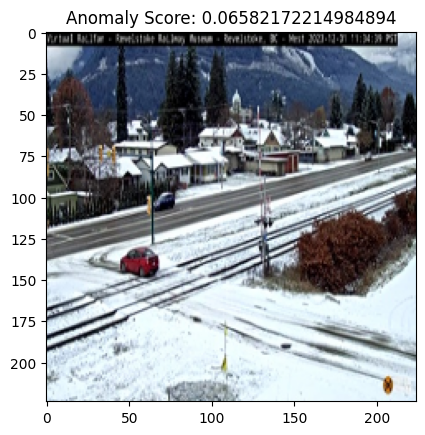

1/1 [==============================] - 0s 18ms/step


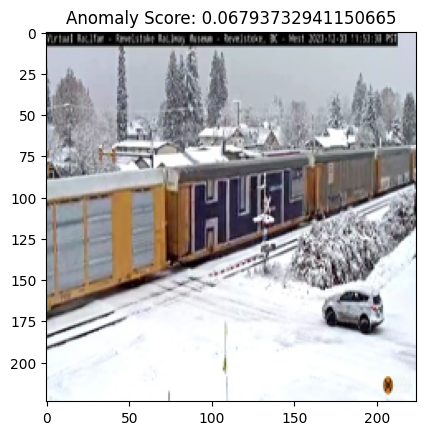

1/1 [==============================] - 0s 17ms/step


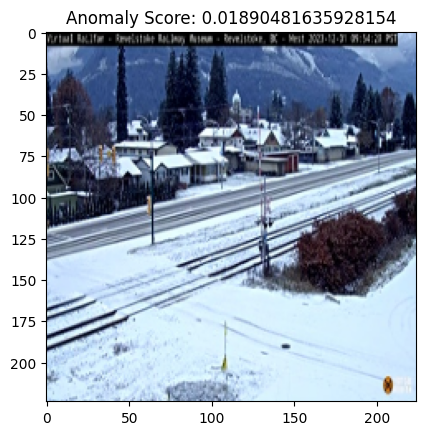

1/1 [==============================] - 0s 15ms/step


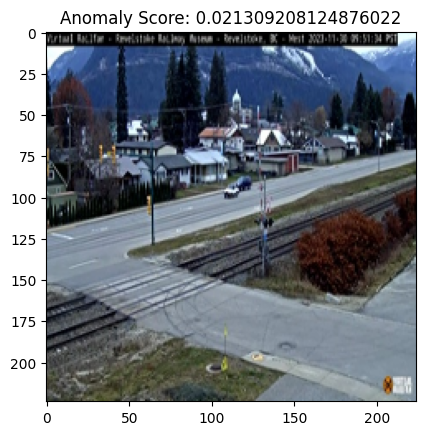

1/1 [==============================] - 0s 16ms/step


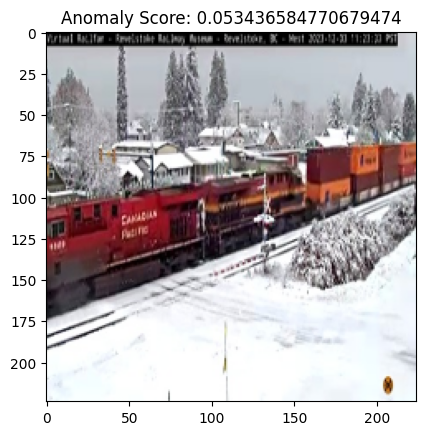

1/1 [==============================] - 0s 46ms/step


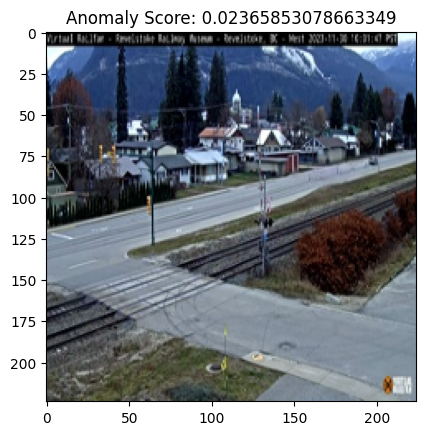

In [10]:
for ix, (x, y) in enumerate(test_ds):
    pred = model.predict(x)

    score = tf.reduce_mean(tf.math.square(x - pred))

    plt.figure()
    plt.imshow(test_data.get_image(ix, apply_mask=False))
    plt.title(f"Anomaly Score: {score}")
    plt.show()